<a href="https://colab.research.google.com/github/erafferty98/refactored-train/blob/master/Copy_of_AMLCWK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Process = create features with AE, select features with RFE + Extratrees, train adaboost classifier for predictions

display.max_colwidth : int or None
    The maximum width in characters of a column in the repr of
    a pandas data structure. When the column overflows, a "..."
    placeholder is embedded in the output. A 'None' value means unlimited.
    [default: 50] [currently: 400]
training data shape (97044, 153)
testing data shape (40158, 153)
             1        2        3  ...      153           154           155
count  97044.0  97044.0  97044.0  ...  97044.0  97044.000000  97044.000000
mean       0.0      0.0      0.0  ...      0.0      0.178474      0.500000
std        0.0      0.0      0.0  ...      0.0      0.360078      0.500003
min        0.0      0.0      0.0  ...      0.0      0.000000      0.000000
25%        0.0      0.0      0.0  ...      0.0      0.000000      0.000000
50%        0.0      0.0      0.0  ...      0.0      0.023873      0.500000
75%        0.0      0.0      0.0  ...      0.0      0.023873      1.000000
max        0.0      0.0      0.0  ...      0.0      1.000000   

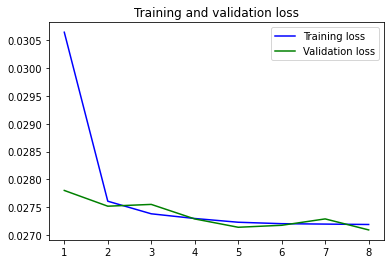

Selected Features indices: [array([  5,   6, 104])]
Feature Ranking: [170 169 168  16  13   1   1  97  96  95  94  40  33  32  50  18 106  15
 114 105 125 126 112  59 132 110  14 121 120 117 142 116 104 139 141  21
 124 108 113 115  11 150 152 153  62  53 159  48  54   6 143 146 154 156
 160 162 164 165   5  22 100  67 103  34  29   2 128  36  55  17   7 123
  63  43  25  51  61  74 137  45  82  83  98  81 129  88  58  10 151 149
  47  24 155 135  87   3 127  99 131 133 134  70  85  66   1  75  23  92
   4  35  90 102 157 158  84  31  78  26  64  42  73 118  80  93  77  89
  91  27 140 147  86 161 163 144 167  65  52   8  76  12  79  69  71  72
 145 136 109 148 111 107 138  60 119  19  49  20 166  68  39 122 101  30
  38  44  37  46   9  57  41  56 130  28]
end RFE extraction

Most important features: [64, 153, 47, 68, 65, 161, 48, 158, 44, 35, 79, 151, 70, 63, 167, 168, 5, 6, 164, 157, 166, 137, 171, 165, 169, 61, 154, 67, 155, 139, 142, 76, 95, 143, 105, 87, 72, 77, 117, 74, 119, 58,

In [ ]:
#Load libraries and data
from pandas import read_csv
from numpy import set_printoptions
import pandas as pd
from pandas import set_option
from numpy import unique
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from __future__ import print_function
from keras.models import Model
from keras.layers import Dense, Input
from keras.regularizers import l1
from keras.optimizers import Adam
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from pandas import read_csv
from matplotlib import pyplot
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from tensorflow.random import set_seed
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.svm import SVC

pd.set_option('max_rows', 99999)
pd.set_option('max_colwidth', 400)
pd.describe_option('max_colwidth')
set_seed(1)
# load csv using pandas
filename = 'test_imperson_without4n7_balanced_data.csv'
testdata = read_csv(filename)
filename = 'train_imperson_without4n7_balanced_data.csv'
traindata = read_csv(filename)


columns = [c for c in traindata.columns if c not in ['155']]
target = '155'

#investigate data
print("training data shape",traindata.shape)
print("testing data shape",testdata.shape)
description = traindata.describe()
print(description)
class_counts = traindata.groupby('155').size()
print(class_counts)
traindata.head()

#train_set, test_set = train_test_split(traindata, test_size=testdata, random_state=42)
columns = [c for c in traindata.columns if c not in ['155']]
target = '155'

x_train = traindata[columns]
y_train = traindata[target]

x_test = testdata[columns]
y_test = testdata[target]

print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)
good = traindata[y_train == 1]
bad = traindata[y_train == 0]
print(good.shape,bad.shape)

normal_duplicates = sum( good.duplicated() )
attack_duplicates = sum( bad.duplicated() )
total_duplicates = normal_duplicates + attack_duplicates

print( 'Normal duplicates', normal_duplicates )
print( 'Attack duplicates', attack_duplicates )
print( 'Total duplicates', total_duplicates )
print( 'Fraction duplicated', total_duplicates / len(traindata) )

df_nUnique = traindata.loc[:, traindata.nunique() == 1]
df_nUnique.head()

def Drop_Redun_Columns(df):
  print (df.shape , 'Traning Data Shape Before drop')
  dfdrop = df.loc[:, df.nunique() != 1]
  print (dfdrop.shape , 'Traning Data Shape After drop')
  return dfdrop

# originally deleted non unique columns but decided to keep. Left code in to see how many are non-unique and how these correlate
unique_training = Drop_Redun_Columns(traindata)
print ("\n")

%matplotlib inline
corrl = unique_training.corr()
plt.imshow(corrl) ;

#stacked autoencoder sparse. used by demise and detered
# split into train test sets
import time
from sklearn.model_selection import train_test_split
from tensorflow.random import set_seed

set_seed(1)

start_time = time.time()
X_train, X_test, Y_train, Y_test= train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# scale data
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)

input_size = 152
hidden_size = 100
hidden_size_2 = 75
hidden_size_3 = 50
code_size = 20
batch_size = 5
input_data = Input(shape=(input_size,))
encoder_1 = Dense(hidden_size, activation='relu')(input_data)
encoder_2 = Dense(hidden_size_2, activation='relu')(encoder_1)
encoder_3 = Dense(hidden_size_3, activation='relu')(encoder_2)
code = Dense(code_size, activation='relu')(encoder_3)
decoder_1 = Dense(hidden_size, activation='relu')(code)
output_data = Dense(input_size, activation='sigmoid')(decoder_1)
autoencoder = Model(input_data, output_data) # autoencoder model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder_train = autoencoder.fit(X_train, X_train, epochs=8,validation_data=(X_test, X_test),batch_size=batch_size)
autoencoder.summary()
encoder = Model(input_data, code) # encoder to create new features

# encode the train data
X_train_encode = encoder.predict(X_train)
# encode the test data
X_test_encode = encoder.predict(X_test)
# define the model
model = LogisticRegression() #use basic logisitic regression to test the autoencoder results
# fit the model on the encoded training set and regular training set
model.fit(X_train_encode, Y_train)
# make predictions on the test set
yhat = model.predict(X_test_encode)
# calculate classification accuracy
acc = accuracy_score(Y_test, yhat)
# now test with original dataset
model = LogisticRegression()
model.fit(x_train, y_train)
yhat2 = model.predict(x_test)
acc2 = accuracy_score(y_test, yhat2)
print("autodencoder lr: ", acc, "\nbase data lr: ",acc2)

# trained the autoencoder and checked the accuracy. Now to encode whole dataset.
# encode the train data
x_train_en = encoder.predict(x_train)
# encode the test data
x_test_en = encoder.predict(x_test)


# sorting out testing/trainng sets
print(type(x_train),type(x_train_en),type(y_train))
x_train_en = pd.DataFrame(x_train_en)
traindata = pd.concat([x_train,x_train_en,y_train],axis=1,ignore_index=True)

x_test_en = pd.DataFrame(x_test_en)
testdata = pd.concat([x_test,x_test_en,y_test],axis=1,ignore_index=True)

print(traindata.shape)
print(traindata.head())
print(testdata.shape)
print(testdata.head())

#split into x and y for feature selection
x_train = traindata[traindata.columns[0:(input_size + code_size)]]
y_train = traindata[traindata.columns[-1]]

x_test = testdata[testdata.columns[0:(input_size + code_size)]]
y_test = testdata[testdata.columns[-1]]

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

import matplotlib.pyplot as plt
from tensorflow.random import set_seed

set_seed(1)
%matplotlib inline
# plot losses
plt.close('all')
plt.figure()
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(1,9)
plt.plot(epochs,loss, 'b-', label='Training loss')
plt.plot(epochs,val_loss, 'g-', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# feature selection
X = x_train
Y = y_train

model = LogisticRegression(solver='liblinear')
# feature extraction with RFE 3 features
from sklearn.feature_selection import RFE

model = LogisticRegression(solver='liblinear',random_state=42)
# feature extraction
rfe = RFE(model, n_features_to_select=3)
fit = rfe.fit(X, Y)
rfebestindices10 = [fit.get_support(indices=True)]
print("Selected Features indices: %s" % rfebestindices10)
print("Feature Ranking: %s" % fit.ranking_)
print("end RFE extraction\n")

# feature extraction with extra trees classifier
from sklearn.ensemble import ExtraTreesClassifier
# feature extraction
extratrees = ExtraTreesClassifier(max_features=4,random_state=42)
fit = extratrees.fit(X, Y)
result = fit.feature_importances_

important_features_dict = {}
for x,i in enumerate(result):
    important_features_dict[x]=i


important_features_list = sorted(important_features_dict,
                                 key=important_features_dict.get,
                                 reverse=True)

print( 'Most important features: %s' %important_features_list)


rfebestindices10_unpacked = list(rfebestindices10[0])
print(rfebestindices10_unpacked)
print(important_features_list[:4])
print(type(rfebestindices10_unpacked))
features = set(rfebestindices10_unpacked + important_features_list[:4])
features = list(features) 
features = sorted(features)
print(features)
#setting X and Y to best results from above
X = traindata.iloc[:,features]
Y = y_train
print(X.shape,Y.shape)
x_test = testdata.iloc[:,features]
print(x_test.shape)

from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, matthews_corrcoef, hamming_loss 
from tensorflow.random import set_seed
from sklearn.metrics import plot_confusion_matrix,roc_curve, jaccard_score,average_precision_score,balanced_accuracy_score
#setting X and Y to best results from above
X = traindata.iloc[:,features]
Y = y_train
print(X.shape,Y.shape)
x_test = testdata.iloc[:,features]
print(x_test.shape)

set_seed(1)
#selected model

#building ML algorithms
set_seed(1)
#model creation
X = traindata.iloc[:,features]
Y = y_train
x_test = testdata.iloc[:,features]

# evaluate model
model = SVC(kernel='linear', gamma=0.1, random_state = 42,probability=True)
kfold = KFold(n_splits=10, random_state=42,shuffle=True)
cv_results = cross_val_score(model, X, Y, cv=kfold, scoring='accuracy')
msg = "Linear SVM: %f (%f)" % (cv_results.mean(), cv_results.std())
print(msg)

%matplotlib inline
#evaluating model and analyzing results
set_seed(1)
#selected model is classifier with logistic regression RFE + extra trees feature selection
model = model.fit(X,Y)
predictions = model.predict(x_test)
#plot ROC AUC
# predict probabilities
probs = model.predict_proba(x_test)
# keep probabilities for the attack outcome only
probs = probs[:,1]
# calculate AUC
auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, predictions),classification_report(y_test, predictions))

def sk_metrix(real_values,pred_values):
   Accuracy = round( accuracy_score(real_values,pred_values) ,4)
   
   Precision  = round(precision_score(real_values,pred_values),4 )
   
   Recall     = round(recall_score(real_values,pred_values),4 )
   F1         = round (f1_score(real_values,pred_values),4)
   MCC        = round (matthews_corrcoef(real_values,pred_values)  ,4)
   Hamming    = round (hamming_loss(real_values,pred_values) ,4)
   Jaccard    = round (jaccard_score(real_values,pred_values) ,4)
   Prec_Avg   = round (average_precision_score(real_values,pred_values) ,4)
   Accu_Avg   = round (balanced_accuracy_score(real_values,pred_values) ,4)
   mat_met = pd.DataFrame({
'Metric': ['Accuracy','Precision','Recall','F1','MCC','Hamming','Jaccard'],
'Value': [Accuracy,Precision,Recall,F1,MCC,Hamming,Jaccard]})
   return (mat_met)

sk_met = sk_metrix(y_test, predictions)
print(sk_met)


In [ ]:
#Load libraries and data
from pandas import read_csv
from numpy import set_printoptions
import pandas as pd
from pandas import set_option
from numpy import unique
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from __future__ import print_function
from keras.models import Model
from keras.layers import Dense, Input
from keras.regularizers import l1
from keras.optimizers import Adam
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from pandas import read_csv
from matplotlib import pyplot
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from tensorflow.random import set_seed
from tensorflow.keras import layers
from tensorflow.keras import regularizers

pd.set_option('max_rows', 99999)
pd.set_option('max_colwidth', 400)
pd.describe_option('max_colwidth')
set_seed(1)
# load csv using pandas
filename = 'test_imperson_without4n7_balanced_data.csv'
testdata = read_csv(filename)
filename = 'train_imperson_without4n7_balanced_data.csv'
traindata = read_csv(filename)


columns = [c for c in traindata.columns if c not in ['155']]
target = '155'

#investigate data
print("training data shape",traindata.shape)
print("testing data shape",testdata.shape)
description = traindata.describe()
print(description)
class_counts = traindata.groupby('155').size()
print(class_counts)
traindata.head()

#train_set, test_set = train_test_split(traindata, test_size=testdata, random_state=42)
columns = [c for c in traindata.columns if c not in ['155']]
target = '155'

x_train = traindata[columns]
y_train = traindata[target]

x_test = testdata[columns]
y_test = testdata[target]

print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)
good = traindata[y_train == 1]
bad = traindata[y_train == 0]
print(good.shape,bad.shape)

normal_duplicates = sum( good.duplicated() )
attack_duplicates = sum( bad.duplicated() )
total_duplicates = normal_duplicates + attack_duplicates

print( 'Normal duplicates', normal_duplicates )
print( 'Attack duplicates', attack_duplicates )
print( 'Total duplicates', total_duplicates )
print( 'Fraction duplicated', total_duplicates / len(traindata) )

df_nUnique = traindata.loc[:, traindata.nunique() == 1]
df_nUnique.head()

def Drop_Redun_Columns(df):
  print (df.shape , 'Traning Data Shape Before drop')
  dfdrop = df.loc[:, df.nunique() != 1]
  print (dfdrop.shape , 'Traning Data Shape After drop')
  return dfdrop

# originally deleted non unique columns but decided to keep. Left code in to see how many are non-unique and how these correlate
unique_training = Drop_Redun_Columns(traindata)
print ("\n")

%matplotlib inline
corrl = unique_training.corr()
plt.imshow(corrl) ;

#stacked autoencoder sparse. used by demise and detered
# split into train test sets
import time
from sklearn.model_selection import train_test_split
from tensorflow.random import set_seed

set_seed(1)

start_time = time.time()
X_train, X_test, Y_train, Y_test= train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# scale data
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)

input_size = 152
hidden_size = 100
hidden_size_2 = 60
hidden_size_3 = 30
code_size = 10
batch_size = 5
input_data = Input(shape=(input_size,))
encoder_1 = Dense(hidden_size, activation='relu')(input_data)
encoder_2 = Dense(hidden_size_2, activation='relu')(encoder_1)
encoder_3 = Dense(hidden_size_3, activation='relu')(encoder_2)
code = Dense(code_size, activation='relu')(encoder_3)
decoder_1 = Dense(hidden_size, activation='relu')(code)
output_data = Dense(input_size, activation='sigmoid')(decoder_1)
autoencoder = Model(input_data, output_data) # autoencoder model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder_train = autoencoder.fit(X_train, X_train, epochs=8,validation_data=(X_test, X_test),batch_size=batch_size)
autoencoder.summary()
encoder = Model(input_data, code) # encoder to create new features

# encode the train data
X_train_encode = encoder.predict(X_train)
# encode the test data
X_test_encode = encoder.predict(X_test)
# define the model
model = LogisticRegression() #use basic logisitic regression to test the autoencoder results
# fit the model on the encoded training set and regular training set
model.fit(X_train_encode, Y_train)
# make predictions on the test set
yhat = model.predict(X_test_encode)
# calculate classification accuracy
acc = accuracy_score(Y_test, yhat)
# now test with original dataset
model = LogisticRegression()
model.fit(x_train, y_train)
yhat2 = model.predict(x_test)
acc2 = accuracy_score(y_test, yhat2)
print("autodencoder lr: ", acc, "\nbase data lr: ",acc2)

# trained the autoencoder and checked the accuracy. Now to encode whole dataset.
# encode the train data
x_train_en = encoder.predict(x_train)
# encode the test data
x_test_en = encoder.predict(x_test)


# sorting out testing/trainng sets
print(type(x_train),type(x_train_en),type(y_train))
x_train_en = pd.DataFrame(x_train_en)
traindata = pd.concat([x_train,x_train_en,y_train],axis=1,ignore_index=True)

x_test_en = pd.DataFrame(x_test_en)
testdata = pd.concat([x_test,x_test_en,y_test],axis=1,ignore_index=True)

print(traindata.shape)
print(traindata.head())
print(testdata.shape)
print(testdata.head())

#split into x and y for feature selection
x_train = traindata[traindata.columns[0:(input_size + code_size)]]
y_train = traindata[traindata.columns[-1]]

x_test = testdata[testdata.columns[0:(input_size + code_size)]]
y_test = testdata[testdata.columns[-1]]

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

import matplotlib.pyplot as plt
from tensorflow.random import set_seed

set_seed(1)
%matplotlib inline
# plot losses
plt.close('all')
plt.figure()
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(1,9)
plt.plot(epochs,loss, 'b-', label='Training loss')
plt.plot(epochs,val_loss, 'g-', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# feature selection
X = x_train
Y = y_train

model = LogisticRegression(solver='liblinear')
# feature extraction with RFE 3 features
from sklearn.feature_selection import RFE

model = LogisticRegression(solver='liblinear',random_state=42)
# feature extraction
rfe = RFE(model, n_features_to_select=3)
fit = rfe.fit(X, Y)
rfebestindices10 = [fit.get_support(indices=True)]
print("Selected Features indices: %s" % rfebestindices10)
print("Feature Ranking: %s" % fit.ranking_)
print("end RFE extraction\n")

# feature extraction with extra trees classifier
from sklearn.ensemble import ExtraTreesClassifier
# feature extraction
extratrees = ExtraTreesClassifier(max_features=4,random_state=42)
fit = extratrees.fit(X, Y)
result = fit.feature_importances_

important_features_dict = {}
for x,i in enumerate(result):
    important_features_dict[x]=i


important_features_list = sorted(important_features_dict,
                                 key=important_features_dict.get,
                                 reverse=True)

print( 'Most important features: %s' %important_features_list)


rfebestindices10_unpacked = list(rfebestindices10[0])
print(rfebestindices10_unpacked)
print(important_features_list[:4])
print(type(rfebestindices10_unpacked))
features = set(rfebestindices10_unpacked + important_features_list[:4])
features = list(features) 
features = sorted(features)
print(features)
#setting X and Y to best results from above
X = traindata.iloc[:,features]
Y = y_train
print(X.shape,Y.shape)
x_test = testdata.iloc[:,features]
print(x_test.shape)

from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, matthews_corrcoef, hamming_loss 
from tensorflow.random import set_seed
from sklearn.metrics import plot_confusion_matrix,roc_curve, jaccard_score,average_precision_score,balanced_accuracy_score
#setting X and Y to best results from above
X = traindata.iloc[:,features]
Y = y_train
print(X.shape,Y.shape)
x_test = testdata.iloc[:,features]
print(x_test.shape)

set_seed(1)
#selected model

#building ML algorithms
set_seed(1)
#model creation
X = traindata.iloc[:,features]
Y = y_train
x_test = testdata.iloc[:,features]

# evaluate model
model = SVC(kernel='linear', gamma=0.1, random_state = 42,probability=True)
kfold = KFold(n_splits=10, random_state=42,shuffle=True)
cv_results = cross_val_score(model, X, Y, cv=kfold, scoring='accuracy')
msg = "Linear SVM: %f (%f)" % (cv_results.mean(), cv_results.std())
print(msg)

%matplotlib inline
#evaluating model and analyzing results
set_seed(1)
#selected model is classifier with logistic regression RFE + extra trees feature selection
model = model.fit(X,Y)
predictions = model.predict(x_test)
#plot ROC AUC
# predict probabilities
probs = model.predict_proba(x_test)
# keep probabilities for the attack outcome only
probs = probs[:,1]
# calculate AUC
auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, predictions),classification_report(y_test, predictions))

def sk_metrix(real_values,pred_values):
   Accuracy = round( accuracy_score(real_values,pred_values) ,4)
   
   Precision  = round(precision_score(real_values,pred_values),4 )
   
   Recall     = round(recall_score(real_values,pred_values),4 )
   F1         = round (f1_score(real_values,pred_values),4)
   MCC        = round (matthews_corrcoef(real_values,pred_values)  ,4)
   Hamming    = round (hamming_loss(real_values,pred_values) ,4)
   Jaccard    = round (jaccard_score(real_values,pred_values) ,4)
   Prec_Avg   = round (average_precision_score(real_values,pred_values) ,4)
   Accu_Avg   = round (balanced_accuracy_score(real_values,pred_values) ,4)
   mat_met = pd.DataFrame({
'Metric': ['Accuracy','Precision','Recall','F1','MCC','Hamming','Jaccard'],
'Value': [Accuracy,Precision,Recall,F1,MCC,Hamming,Jaccard]})
   return (mat_met)

sk_met = sk_metrix(y_test, predictions)
print(sk_met)


In [ ]:
#Load libraries and data
from pandas import read_csv
from numpy import set_printoptions
import pandas as pd
from pandas import set_option
from numpy import unique
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from __future__ import print_function
from keras.models import Model
from keras.layers import Dense, Input
from keras.regularizers import l1
from keras.optimizers import Adam
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from pandas import read_csv
from matplotlib import pyplot
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from tensorflow.random import set_seed
from tensorflow.keras import layers
from tensorflow.keras import regularizers

pd.set_option('max_rows', 99999)
pd.set_option('max_colwidth', 400)
pd.describe_option('max_colwidth')
set_seed(1)
# load csv using pandas
filename = 'test_imperson_without4n7_balanced_data.csv'
testdata = read_csv(filename)
filename = 'train_imperson_without4n7_balanced_data.csv'
traindata = read_csv(filename)


columns = [c for c in traindata.columns if c not in ['155']]
target = '155'

#investigate data
print("training data shape",traindata.shape)
print("testing data shape",testdata.shape)
description = traindata.describe()
print(description)
class_counts = traindata.groupby('155').size()
print(class_counts)
traindata.head()

#train_set, test_set = train_test_split(traindata, test_size=testdata, random_state=42)
columns = [c for c in traindata.columns if c not in ['155']]
target = '155'

x_train = traindata[columns]
y_train = traindata[target]

x_test = testdata[columns]
y_test = testdata[target]

print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)
good = traindata[y_train == 1]
bad = traindata[y_train == 0]
print(good.shape,bad.shape)

normal_duplicates = sum( good.duplicated() )
attack_duplicates = sum( bad.duplicated() )
total_duplicates = normal_duplicates + attack_duplicates

print( 'Normal duplicates', normal_duplicates )
print( 'Attack duplicates', attack_duplicates )
print( 'Total duplicates', total_duplicates )
print( 'Fraction duplicated', total_duplicates / len(traindata) )

df_nUnique = traindata.loc[:, traindata.nunique() == 1]
df_nUnique.head()

def Drop_Redun_Columns(df):
  print (df.shape , 'Traning Data Shape Before drop')
  dfdrop = df.loc[:, df.nunique() != 1]
  print (dfdrop.shape , 'Traning Data Shape After drop')
  return dfdrop

# originally deleted non unique columns but decided to keep. Left code in to see how many are non-unique and how these correlate
unique_training = Drop_Redun_Columns(traindata)
print ("\n")

%matplotlib inline
corrl = unique_training.corr()
plt.imshow(corrl) ;

#stacked autoencoder sparse. used by demise and detered
# split into train test sets
import time
from sklearn.model_selection import train_test_split
from tensorflow.random import set_seed

set_seed(1)

start_time = time.time()
X_train, X_test, Y_train, Y_test= train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# scale data
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)

input_size = 152
hidden_size = 100
hidden_size_2 = 80
hidden_size_3 = 60
code_size = 40
batch_size = 5
input_data = Input(shape=(input_size,))
encoder_1 = Dense(hidden_size, activation='relu')(input_data)
encoder_2 = Dense(hidden_size_2, activation='relu')(encoder_1)
encoder_3 = Dense(hidden_size_3, activation='relu')(encoder_2)
code = Dense(code_size, activation='relu')(encoder_3)
decoder_1 = Dense(hidden_size, activation='relu')(code)
output_data = Dense(input_size, activation='sigmoid')(decoder_1)
autoencoder = Model(input_data, output_data) # autoencoder model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder_train = autoencoder.fit(X_train, X_train, epochs=8,validation_data=(X_test, X_test),batch_size=batch_size)
autoencoder.summary()
encoder = Model(input_data, code) # encoder to create new features

# encode the train data
X_train_encode = encoder.predict(X_train)
# encode the test data
X_test_encode = encoder.predict(X_test)
# define the model
model = LogisticRegression() #use basic logisitic regression to test the autoencoder results
# fit the model on the encoded training set and regular training set
model.fit(X_train_encode, Y_train)
# make predictions on the test set
yhat = model.predict(X_test_encode)
# calculate classification accuracy
acc = accuracy_score(Y_test, yhat)
# now test with original dataset
model = LogisticRegression()
model.fit(x_train, y_train)
yhat2 = model.predict(x_test)
acc2 = accuracy_score(y_test, yhat2)
print("autodencoder lr: ", acc, "\nbase data lr: ",acc2)

# trained the autoencoder and checked the accuracy. Now to encode whole dataset.
# encode the train data
x_train_en = encoder.predict(x_train)
# encode the test data
x_test_en = encoder.predict(x_test)


# sorting out testing/trainng sets
print(type(x_train),type(x_train_en),type(y_train))
x_train_en = pd.DataFrame(x_train_en)
traindata = pd.concat([x_train,x_train_en,y_train],axis=1,ignore_index=True)

x_test_en = pd.DataFrame(x_test_en)
testdata = pd.concat([x_test,x_test_en,y_test],axis=1,ignore_index=True)

print(traindata.shape)
print(traindata.head())
print(testdata.shape)
print(testdata.head())

#split into x and y for feature selection
x_train = traindata[traindata.columns[0:(input_size + code_size)]]
y_train = traindata[traindata.columns[-1]]

x_test = testdata[testdata.columns[0:(input_size + code_size)]]
y_test = testdata[testdata.columns[-1]]

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

import matplotlib.pyplot as plt
from tensorflow.random import set_seed

set_seed(1)
%matplotlib inline
# plot losses
plt.close('all')
plt.figure()
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(1,9)
plt.plot(epochs,loss, 'b-', label='Training loss')
plt.plot(epochs,val_loss, 'g-', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# feature selection
X = x_train
Y = y_train

model = LogisticRegression(solver='liblinear')
# feature extraction with RFE 3 features
from sklearn.feature_selection import RFE

model = LogisticRegression(solver='liblinear',random_state=42)
# feature extraction
rfe = RFE(model, n_features_to_select=3)
fit = rfe.fit(X, Y)
rfebestindices10 = [fit.get_support(indices=True)]
print("Selected Features indices: %s" % rfebestindices10)
print("Feature Ranking: %s" % fit.ranking_)
print("end RFE extraction\n")

# feature extraction with extra trees classifier
from sklearn.ensemble import ExtraTreesClassifier
# feature extraction
extratrees = ExtraTreesClassifier(max_features=4,random_state=42)
fit = extratrees.fit(X, Y)
result = fit.feature_importances_

important_features_dict = {}
for x,i in enumerate(result):
    important_features_dict[x]=i


important_features_list = sorted(important_features_dict,
                                 key=important_features_dict.get,
                                 reverse=True)

print( 'Most important features: %s' %important_features_list)


rfebestindices10_unpacked = list(rfebestindices10[0])
print(rfebestindices10_unpacked)
print(important_features_list[:4])
print(type(rfebestindices10_unpacked))
features = set(rfebestindices10_unpacked + important_features_list[:4])
features = list(features) 
features = sorted(features)
print(features)
#setting X and Y to best results from above
X = traindata.iloc[:,features]
Y = y_train
print(X.shape,Y.shape)
x_test = testdata.iloc[:,features]
print(x_test.shape)

from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, matthews_corrcoef, hamming_loss 
from tensorflow.random import set_seed
from sklearn.metrics import plot_confusion_matrix,roc_curve, jaccard_score,average_precision_score,balanced_accuracy_score
#setting X and Y to best results from above
X = traindata.iloc[:,features]
Y = y_train
print(X.shape,Y.shape)
x_test = testdata.iloc[:,features]
print(x_test.shape)

set_seed(1)
#selected model

#building ML algorithms
set_seed(1)
#model creation
X = traindata.iloc[:,features]
Y = y_train
x_test = testdata.iloc[:,features]

# evaluate model
model = SVC(kernel='linear', gamma=0.1, random_state = 42,probability=True)
kfold = KFold(n_splits=10, random_state=42,shuffle=True)
cv_results = cross_val_score(model, X, Y, cv=kfold, scoring='accuracy')
msg = "Linear SVM: %f (%f)" % (cv_results.mean(), cv_results.std())
print(msg)

%matplotlib inline
#evaluating model and analyzing results
set_seed(1)
#selected model is classifier with logistic regression RFE + extra trees feature selection
model = model.fit(X,Y)
predictions = model.predict(x_test)
#plot ROC AUC
# predict probabilities
probs = model.predict_proba(x_test)
# keep probabilities for the attack outcome only
probs = probs[:,1]
# calculate AUC
auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, predictions),classification_report(y_test, predictions))

def sk_metrix(real_values,pred_values):
   Accuracy = round( accuracy_score(real_values,pred_values) ,4)
   
   Precision  = round(precision_score(real_values,pred_values),4 )
   
   Recall     = round(recall_score(real_values,pred_values),4 )
   F1         = round (f1_score(real_values,pred_values),4)
   MCC        = round (matthews_corrcoef(real_values,pred_values)  ,4)
   Hamming    = round (hamming_loss(real_values,pred_values) ,4)
   Jaccard    = round (jaccard_score(real_values,pred_values) ,4)
   Prec_Avg   = round (average_precision_score(real_values,pred_values) ,4)
   Accu_Avg   = round (balanced_accuracy_score(real_values,pred_values) ,4)
   mat_met = pd.DataFrame({
'Metric': ['Accuracy','Precision','Recall','F1','MCC','Hamming','Jaccard'],
'Value': [Accuracy,Precision,Recall,F1,MCC,Hamming,Jaccard]})
   return (mat_met)

sk_met = sk_metrix(y_test, predictions)
print(sk_met)


In [ ]:
#Load libraries and data
from pandas import read_csv
from numpy import set_printoptions
import pandas as pd
from pandas import set_option
from numpy import unique
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from __future__ import print_function
from keras.models import Model
from keras.layers import Dense, Input
from keras.regularizers import l1
from keras.optimizers import Adam
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from pandas import read_csv
from matplotlib import pyplot
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from tensorflow.random import set_seed
from tensorflow.keras import layers
from tensorflow.keras import regularizers

pd.set_option('max_rows', 99999)
pd.set_option('max_colwidth', 400)
pd.describe_option('max_colwidth')
set_seed(1)
# load csv using pandas
filename = 'test_imperson_without4n7_balanced_data.csv'
testdata = read_csv(filename)
filename = 'train_imperson_without4n7_balanced_data.csv'
traindata = read_csv(filename)


columns = [c for c in traindata.columns if c not in ['155']]
target = '155'

#investigate data
print("training data shape",traindata.shape)
print("testing data shape",testdata.shape)
description = traindata.describe()
print(description)
class_counts = traindata.groupby('155').size()
print(class_counts)
traindata.head()

#train_set, test_set = train_test_split(traindata, test_size=testdata, random_state=42)
columns = [c for c in traindata.columns if c not in ['155']]
target = '155'

x_train = traindata[columns]
y_train = traindata[target]

x_test = testdata[columns]
y_test = testdata[target]

print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)
good = traindata[y_train == 1]
bad = traindata[y_train == 0]
print(good.shape,bad.shape)

normal_duplicates = sum( good.duplicated() )
attack_duplicates = sum( bad.duplicated() )
total_duplicates = normal_duplicates + attack_duplicates

print( 'Normal duplicates', normal_duplicates )
print( 'Attack duplicates', attack_duplicates )
print( 'Total duplicates', total_duplicates )
print( 'Fraction duplicated', total_duplicates / len(traindata) )

df_nUnique = traindata.loc[:, traindata.nunique() == 1]
df_nUnique.head()

def Drop_Redun_Columns(df):
  print (df.shape , 'Traning Data Shape Before drop')
  dfdrop = df.loc[:, df.nunique() != 1]
  print (dfdrop.shape , 'Traning Data Shape After drop')
  return dfdrop

# originally deleted non unique columns but decided to keep. Left code in to see how many are non-unique and how these correlate
unique_training = Drop_Redun_Columns(traindata)
print ("\n")

%matplotlib inline
corrl = unique_training.corr()
plt.imshow(corrl) ;

#stacked autoencoder sparse. used by demise and detered
# split into train test sets
import time
from sklearn.model_selection import train_test_split
from tensorflow.random import set_seed

set_seed(1)

start_time = time.time()
X_train, X_test, Y_train, Y_test= train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# scale data
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)

input_size = 152
hidden_size = 100
hidden_size_2 = 80
hidden_size_3 = 60
code_size = 10
batch_size = 5
input_data = Input(shape=(input_size,))
encoder_1 = Dense(hidden_size, activation='relu')(input_data)
encoder_2 = Dense(hidden_size_2, activation='relu')(encoder_1)
encoder_3 = Dense(hidden_size_3, activation='relu')(encoder_2)
code = Dense(code_size, activation='relu')(encoder_3)
decoder_1 = Dense(hidden_size, activation='relu')(code)
output_data = Dense(input_size, activation='sigmoid')(decoder_1)
autoencoder = Model(input_data, output_data) # autoencoder model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder_train = autoencoder.fit(X_train, X_train, epochs=8,validation_data=(X_test, X_test),batch_size=batch_size)
autoencoder.summary()
encoder = Model(input_data, code) # encoder to create new features

# encode the train data
X_train_encode = encoder.predict(X_train)
# encode the test data
X_test_encode = encoder.predict(X_test)
# define the model
model = LogisticRegression() #use basic logisitic regression to test the autoencoder results
# fit the model on the encoded training set and regular training set
model.fit(X_train_encode, Y_train)
# make predictions on the test set
yhat = model.predict(X_test_encode)
# calculate classification accuracy
acc = accuracy_score(Y_test, yhat)
# now test with original dataset
model = LogisticRegression()
model.fit(x_train, y_train)
yhat2 = model.predict(x_test)
acc2 = accuracy_score(y_test, yhat2)
print("autodencoder lr: ", acc, "\nbase data lr: ",acc2)

# trained the autoencoder and checked the accuracy. Now to encode whole dataset.
# encode the train data
x_train_en = encoder.predict(x_train)
# encode the test data
x_test_en = encoder.predict(x_test)


# sorting out testing/trainng sets
print(type(x_train),type(x_train_en),type(y_train))
x_train_en = pd.DataFrame(x_train_en)
traindata = pd.concat([x_train,x_train_en,y_train],axis=1,ignore_index=True)

x_test_en = pd.DataFrame(x_test_en)
testdata = pd.concat([x_test,x_test_en,y_test],axis=1,ignore_index=True)

print(traindata.shape)
print(traindata.head())
print(testdata.shape)
print(testdata.head())

#split into x and y for feature selection
x_train = traindata[traindata.columns[0:(input_size + code_size)]]
y_train = traindata[traindata.columns[-1]]

x_test = testdata[testdata.columns[0:(input_size + code_size)]]
y_test = testdata[testdata.columns[-1]]

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

import matplotlib.pyplot as plt
from tensorflow.random import set_seed

set_seed(1)
%matplotlib inline
# plot losses
plt.close('all')
plt.figure()
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(1,9)
plt.plot(epochs,loss, 'b-', label='Training loss')
plt.plot(epochs,val_loss, 'g-', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# feature selection
X = x_train
Y = y_train

model = LogisticRegression(solver='liblinear')
# feature extraction with RFE 3 features
from sklearn.feature_selection import RFE

model = LogisticRegression(solver='liblinear',random_state=42)
# feature extraction
rfe = RFE(model, n_features_to_select=3)
fit = rfe.fit(X, Y)
rfebestindices10 = [fit.get_support(indices=True)]
print("Selected Features indices: %s" % rfebestindices10)
print("Feature Ranking: %s" % fit.ranking_)
print("end RFE extraction\n")

# feature extraction with extra trees classifier
from sklearn.ensemble import ExtraTreesClassifier
# feature extraction
extratrees = ExtraTreesClassifier(max_features=3,random_state=42)
fit = extratrees.fit(X, Y)
result = fit.feature_importances_

important_features_dict = {}
for x,i in enumerate(result):
    important_features_dict[x]=i


important_features_list = sorted(important_features_dict,
                                 key=important_features_dict.get,
                                 reverse=True)

print( 'Most important features: %s' %important_features_list)


rfebestindices10_unpacked = list(rfebestindices10[0])
print(rfebestindices10_unpacked)
print(important_features_list[:4])
print(type(rfebestindices10_unpacked))
features = set(rfebestindices10_unpacked + important_features_list[:4])
features = list(features) 
features = sorted(features)
print(features)
#setting X and Y to best results from above
X = traindata.iloc[:,features]
Y = y_train
print(X.shape,Y.shape)
x_test = testdata.iloc[:,features]
print(x_test.shape)

from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, matthews_corrcoef, hamming_loss 
from tensorflow.random import set_seed
from sklearn.metrics import plot_confusion_matrix,roc_curve, jaccard_score,average_precision_score,balanced_accuracy_score
#setting X and Y to best results from above
X = traindata.iloc[:,features]
Y = y_train
print(X.shape,Y.shape)
x_test = testdata.iloc[:,features]
print(x_test.shape)

set_seed(1)
#selected model

#building ML algorithms
set_seed(1)
#model creation
X = traindata.iloc[:,features]
Y = y_train
x_test = testdata.iloc[:,features]

# evaluate model
model = SVC(kernel='linear', gamma=0.1, random_state = 42,probability=True)
kfold = KFold(n_splits=10, random_state=42,shuffle=True)
cv_results = cross_val_score(model, X, Y, cv=kfold, scoring='accuracy')
msg = "Linear SVM: %f (%f)" % (cv_results.mean(), cv_results.std())
print(msg)

%matplotlib inline
#evaluating model and analyzing results
set_seed(1)
#selected model is classifier with logistic regression RFE + extra trees feature selection
model = model.fit(X,Y)
predictions = model.predict(x_test)
#plot ROC AUC
# predict probabilities
probs = model.predict_proba(x_test)
# keep probabilities for the attack outcome only
probs = probs[:,1]
# calculate AUC
auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, predictions),classification_report(y_test, predictions))

def sk_metrix(real_values,pred_values):
   Accuracy = round( accuracy_score(real_values,pred_values) ,4)
   
   Precision  = round(precision_score(real_values,pred_values),4 )
   
   Recall     = round(recall_score(real_values,pred_values),4 )
   F1         = round (f1_score(real_values,pred_values),4)
   MCC        = round (matthews_corrcoef(real_values,pred_values)  ,4)
   Hamming    = round (hamming_loss(real_values,pred_values) ,4)
   Jaccard    = round (jaccard_score(real_values,pred_values) ,4)
   Prec_Avg   = round (average_precision_score(real_values,pred_values) ,4)
   Accu_Avg   = round (balanced_accuracy_score(real_values,pred_values) ,4)
   mat_met = pd.DataFrame({
'Metric': ['Accuracy','Precision','Recall','F1','MCC','Hamming','Jaccard'],
'Value': [Accuracy,Precision,Recall,F1,MCC,Hamming,Jaccard]})
   return (mat_met)

sk_met = sk_metrix(y_test, predictions)
print(sk_met)


In [ ]:
set_seed(1)
# feature selection
X = x_train
Y = y_train

model = LogisticRegression(solver='liblinear')
# feature extraction with RFE 4 features
from sklearn.feature_selection import RFE

model = LogisticRegression(solver='liblinear',random_state=42)
# feature extraction
rfe = RFE(model, n_features_to_select=3)
fit = rfe.fit(X, Y)
rfebestindices10 = [fit.get_support(indices=True)]
print("Selected Features indices: %s" % rfebestindices10)
print("Feature Ranking: %s" % fit.ranking_)
print("end RFE extraction\n")

# feature extraction with extra trees classifier
from sklearn.ensemble import ExtraTreesClassifier
# feature extraction
extratrees = ExtraTreesClassifier(max_features=4,random_state=42)
fit = extratrees.fit(X, Y)
result = fit.feature_importances_

important_features_dict = {}
for x,i in enumerate(result):
    important_features_dict[x]=i


important_features_list = sorted(important_features_dict,
                                 key=important_features_dict.get,
                                 reverse=True)

print( 'Most important features: %s' %important_features_list)


rfebestindices10_unpacked = list(rfebestindices10[0])
print(rfebestindices10_unpacked)
print(important_features_list[:5])
print(type(rfebestindices10_unpacked))
features = set(rfebestindices10_unpacked + important_features_list[:4])
features = list(features) 
features = sorted(features)
print(features)
#setting X and Y to best results from above
X = traindata.iloc[:,features]
Y = y_train
print(X.shape,Y.shape)
x_test = testdata.iloc[:,features]
print(x_test.shape)

from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, matthews_corrcoef, hamming_loss 
from tensorflow.random import set_seed
from sklearn.metrics import plot_confusion_matrix,roc_curve, jaccard_score,average_precision_score,balanced_accuracy_score
#setting X and Y to best results from above
X = traindata.iloc[:,features]
Y = y_train
print(X.shape,Y.shape)
x_test = testdata.iloc[:,features]
print(x_test.shape)

set_seed(1)
#selected model

#building ML algorithms
set_seed(1)
#model creation
X = traindata.iloc[:,features]
Y = y_train
x_test = testdata.iloc[:,features]
# prepare models
models = []
models.append(('LR', LogisticRegression(solver='liblinear',random_state = 42)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('ADABOOST CLASSIFIER',AdaBoostClassifier()))
models.append(('linear SVM',SVC(kernel='linear', gamma=0.1, random_state = 42)))


# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
  kfold = KFold(n_splits=10, random_state=42,shuffle=True)
  cv_results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)
  clf = model
  clf.fit(X, Y)
  y_pred = model.predict(x_test)
  print(confusion_matrix(y_test, y_pred))
  print(classification_report(y_test, y_pred))

# evaluate model
model = SVC(kernel='linear', gamma=0.1, random_state = 42)
kfold = KFold(n_splits=10, random_state=42,shuffle=True)
cv_results = cross_val_score(model, X, Y, cv=kfold, scoring='accuracy')
msg = "Adaboost Classifier: %f (%f)" % (cv_results.mean(), cv_results.std())
print(msg)

%matplotlib inline
#evaluating model and analyzing results
set_seed(1)
#selected model is adaboost classifier with logistic regression RFE + extra trees feature selection
model = model.fit(X,Y)
predictions = model.predict(x_test)
#plot ROC AUC
# predict probabilities
probs = model.predict_proba(x_test)
# keep probabilities for the attack outcome only
probs = probs[:,1]
# calculate AUC
auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, predictions),classification_report(y_test, predictions))

def sk_metrix(real_values,pred_values):
   Accuracy = round( accuracy_score(real_values,pred_values) ,4)
   
   Precision  = round(precision_score(real_values,pred_values),4 )
   
   Recall     = round(recall_score(real_values,pred_values),4 )
   F1         = round (f1_score(real_values,pred_values),4)
   MCC        = round (matthews_corrcoef(real_values,pred_values)  ,4)
   Hamming    = round (hamming_loss(real_values,pred_values) ,4)
   Jaccard    = round (jaccard_score(real_values,pred_values) ,4)
   Prec_Avg   = round (average_precision_score(real_values,pred_values) ,4)
   Accu_Avg   = round (balanced_accuracy_score(real_values,pred_values) ,4)
   mat_met = pd.DataFrame({
'Metric': ['Accuracy','Precision','Recall','F1','MCC','Hamming','Jaccard'],
'Value': [Accuracy,Precision,Recall,F1,MCC,Hamming,Jaccard]})
   return (mat_met)

sk_met = sk_metrix(y_test, predictions)
print(sk_met)

Selected Features indices: [array([  6,  70, 104])]
Feature Ranking: [160 159 158  19  16  13   1  90  89  88  87  52  51  50  63  48  86  59
  97  92 104 102 106  46 122 114  45 115 117 128 120 134 136 138 140   3
 144 146 145 143  44 127 129 125  30  61 123  39  29  40  99  96 108 130
 147 149 152 154   6  60 142  55 113  36  22  12 111   4  53   5   1 107
  35  34  31  21  24  62 124  10  84  80 157  82 141  85  58  17 112 116
  18  11 135 137  81  15  94 110  98 103 121  25  70  43   1  69  27  74
  23  14  77 148 100 109  83   2  67  26  42  28  38 132  72  78  64  75
  76   9  91  95  79 133 131 101 105  68  66   7  65  20  71  73  57  54
 150 118 153 155 156 151 126  41  56 139  49   8 119  32  33  93  37  47]
end RFE extraction

Most important features: [64, 47, 68, 44, 70, 65, 48, 6, 160, 79, 151, 137, 5, 155, 35, 158, 61, 63, 157, 152, 139, 142, 77, 58, 107, 161, 105, 76, 119, 143, 67, 95, 104, 115, 87, 91, 75, 123, 116, 117, 127, 125, 138, 154, 72, 140, 90, 74, 124, 126, 4, 

AttributeError: ignored

In [ ]:
#building ML algorithms
set_seed(1)
#model creation
X = traindata.iloc[:,features]
Y = y_train
x_test = testdata.iloc[:,features]
# prepare models
models = []
models.append(('LR', LogisticRegression(solver='liblinear',random_state = 42)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('ADABOOST CLASSIFIER',AdaBoostClassifier()))
models.append(('linear SVM',SVC(kernel='linear', gamma=0.1, random_state = 42)))


# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
  kfold = KFold(n_splits=10, random_state=42,shuffle=True)
  cv_results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)
  clf = model
  clf.fit(X, Y)
  y_pred = model.predict(x_test)
  print(confusion_matrix(y_test, y_pred))
  print(classification_report(y_test, y_pred))

LR: 0.972693 (0.001685)
[[18253  1826]
 [   70 20009]]
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     20079
           1       0.92      1.00      0.95     20079

    accuracy                           0.95     40158
   macro avg       0.96      0.95      0.95     40158
weighted avg       0.96      0.95      0.95     40158

LDA: 0.960265 (0.001673)
[[17903  2176]
 [   31 20048]]
              precision    recall  f1-score   support

           0       1.00      0.89      0.94     20079
           1       0.90      1.00      0.95     20079

    accuracy                           0.95     40158
   macro avg       0.95      0.95      0.94     40158
weighted avg       0.95      0.95      0.94     40158

Naive Bayes: 0.956298 (0.004321)
[[18455  1624]
 [20072     7]]
              precision    recall  f1-score   support

           0       0.48      0.92      0.63     20079
           1       0.00      0.00      0.00     20079

    acc

In [ ]:
print(features)

[44, 61, 64, 104, 127, 127]


# **Appendix - containing extra code**
not used for model but ran in order to find best results